In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install pydub numpy

In [ ]:
from pydub import AudioSegment
import numpy as np
silence_thresh = 45.00

# Load audio file
def load_audio(file_path):
    return AudioSegment.from_file(file_path)

# Detect and remove silences
def remove_silence(audio, silence_thresh=-silence_thresh, chunk_size=10):
    # Break audio into chunks of size chunk_size (in ms)
    chunks = [audio[i:i + chunk_size] for i in range(0, len(audio), chunk_size)]

    non_silent_chunks = []
    for chunk in chunks:
        # Calculate the average dBFS (volume) of the chunk
        if chunk.dBFS > silence_thresh:
            non_silent_chunks.append(chunk)

    return sum(non_silent_chunks)

# Save the resulting audio
def save_audio(audio, output_path):
    audio.export(output_path, format="wav")

# Parameters
input_file = "/content/drive/MyDrive/SIH/audios/combined_audio.wav"
output_file = "output_audio.wav"

# Load the audio file
audio = load_audio(input_file)

# Remove silences below -50 dBFS
processed_audio = remove_silence(audio, silence_thresh=-45.0, chunk_size=10)

# Save the processed audio to a new file
save_audio(processed_audio, output_file)


In [ ]:
from pydub import AudioSegment

# Load the .wav audio file
audio = AudioSegment.from_wav("/content/drive/MyDrive/SIH/audios/combined_audio.wav")

# Get the duration in seconds
duration = len(audio) / 1000  # pydub returns milliseconds, so divide by 1000

print(f"Duration: {duration} seconds")


Duration: 160.0 seconds


In [ ]:
from pydub import AudioSegment

# Load the .wav audio file
audio = AudioSegment.from_wav("output_audio.wav")

# Get the duration in seconds
duration = len(audio) / 1000  # pydub returns milliseconds, so divide by 1000

print(f"Duration: {duration} seconds")


Duration: 141.67 seconds


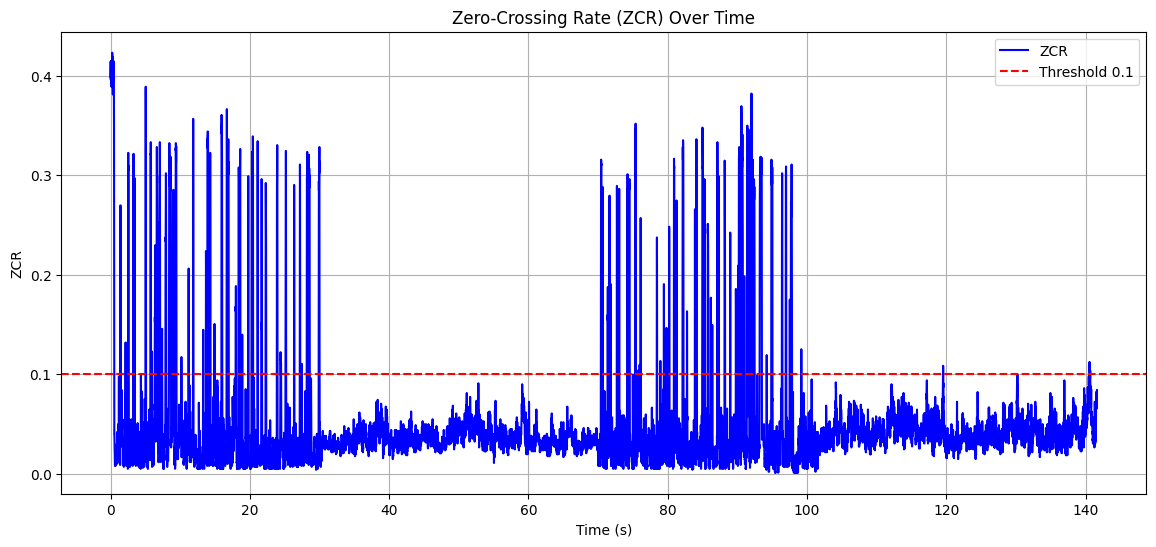

Total duration of the audio: 141.67 seconds
Time duration where ZCR is below 0.1 (noise): 85.12 seconds
Time duration where ZCR is above 0.1 (voice): 56.55 seconds


In [ ]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import csv

# Load the audio file
sample_rate, data = wav.read('/content/output_audio.wav')

# Convert to mono if the audio is stereo (2D array)
if len(data.shape) > 1:
    data = np.mean(data, axis=1)

# Parameters
frame_size = 1024
hop_size = 512
time_threshold = 1.5  # seconds
frames_per_second = sample_rate / hop_size
frames_per_time_threshold = int(time_threshold * frames_per_second)

# Initialize arrays to store feature values
zcr_values = []

# Calculate ZCR for each frame
for i in range(0, len(data) - frame_size, hop_size):
    frame = data[i:i + frame_size]
    zcr = np.mean(np.abs(np.diff(np.sign(frame)))) / 2
    zcr_values.append(zcr)

# Convert lists to numpy arrays
zcr_values = np.array(zcr_values)

# Time axis for the frames
time_axis = np.arange(0, len(zcr_values)) * hop_size / sample_rate

# Initialize durations
time_below_threshold = 0
time_above_threshold = 0

# Analyze ZCR values
i = 0
while i < len(zcr_values):
    if zcr_values[i] < 0.1:
        count = 0
        # Check if the ZCR stays below 0.1 for the next frames_per_time_threshold frames
        while i + count < len(zcr_values) and zcr_values[i + count] < 0.1:
            count += 1
            if count >= frames_per_time_threshold:
                # If condition is met for at least 1 second, count the duration
                time_below_threshold += count * hop_size / sample_rate
                i += count
                break
        else:
            # If the condition is not met, move to the next frame
            i += count
    else:
        count = 0
        # Check if the ZCR stays above 0.1
        while i + count < len(zcr_values) and zcr_values[i + count] >= 0.1:
            count += 1
            time_above_threshold += count * hop_size / sample_rate
            i += count

# Plot the ZCR values
plt.figure(figsize=(14, 6))
plt.plot(time_axis, zcr_values, label='ZCR', color='blue')
plt.axhline(y=0.1, color='r', linestyle='--', label='Threshold 0.1')
plt.title('Zero-Crossing Rate (ZCR) Over Time')
plt.xlabel('Time (s)')
plt.ylabel('ZCR')
plt.legend()
plt.grid(True)
plt.show()

# Save the results to a CSV file
with open('noise_detection.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['status', 'duration(seconds)'])
    writer.writerow(['noise', time_below_threshold])
    writer.writerow(['voice', time_above_threshold])

# Print the time durations
# Load the audio file
audio_dir = '/content/output_audio.wav'  # Replace with your audio file path
sample_rate, data = wav.read(audio_dir)
# Calculate the total duration in seconds
total_duration = len(data) / sample_rate

print(f"Total duration of the audio: {total_duration:.2f} seconds")

time_above_threshold = total_duration-time_below_threshold
print(f"Time duration where ZCR is below 0.1 (noise): {time_below_threshold:.2f} seconds")
print(f"Time duration where ZCR is above 0.1 (voice): {time_above_threshold:.2f} seconds")


In [ ]:
import numpy as np
import scipy.io.wavfile as wav
from pydub import AudioSegment
import csv

# Load the audio file
audio_dir = '/content/output_audio.wav'  # Replace with your audio file path
sample_rate, data = wav.read(audio_dir)

# Convert to mono if the audio is stereo (2D array)
if len(data.shape) > 1:
    data = np.mean(data, axis=1)

# Parameters
frame_size = 1024
hop_size = 512
time_threshold = 1.5  # seconds
frames_per_second = sample_rate / hop_size
frames_per_time_threshold = int(time_threshold * frames_per_second)

# Initialize arrays to store feature values
zcr_values = []
noise_segments = []
voice_segments = []

# Calculate ZCR for each frame
for i in range(0, len(data) - frame_size, hop_size):
    frame = data[i:i + frame_size]
    zcr = np.mean(np.abs(np.diff(np.sign(frame)))) / 2
    zcr_values.append(zcr)

# Convert lists to numpy arrays
zcr_values = np.array(zcr_values)

# Time axis for the frames
time_axis = np.arange(0, len(zcr_values)) * hop_size / sample_rate

# Audio segment initialization
audio_segment = AudioSegment.from_wav(audio_dir)

i = 0
while i < len(zcr_values):
    if zcr_values[i] < 0.1:
        count = 0
        start_time = i * hop_size / sample_rate  # Convert to seconds
        # Check if the ZCR stays below 0.1 for the next frames_per_time_threshold frames
        while i + count < len(zcr_values) and zcr_values[i + count] < 0.1:
            count += 1
            if count >= frames_per_time_threshold:
                # If condition is met for at least 1.5 seconds, count the duration
                end_time = (i + count) * hop_size / sample_rate  # Convert to seconds

                # Append the noise segment and its timing to the list
                noise_segments.append({'start_time': start_time, 'end_time': end_time})

                i += count
                break
        else:
            # If the condition is not met, move to the next frame
            i += count
    else:
        count = 0
        start_time = i * hop_size / sample_rate  # Convert to seconds
        # Track time where ZCR is above 0.1
        while i + count < len(zcr_values) and zcr_values[i + count] >= 0.1:
            count += 1
            end_time = (i + count) * hop_size / sample_rate  # Convert to seconds
            i += count

        # if end_time > start_time:
            # voice_segments.append({'start_time': start_time, 'end_time': end_time})

# Combine overlapping noise segments
combined_noise_segments = []
if noise_segments:
    current_segment = noise_segments[0]
    for segment in noise_segments[1:]:
        if segment['start_time'] <= current_segment['end_time'] + 2:  # Overlap or adjacent
            current_segment['end_time'] = max(current_segment['end_time'], segment['end_time'])
        else:
            combined_noise_segments.append(current_segment)
            current_segment = segment
    combined_noise_segments.append(current_segment)  # Append the last combined segment

# Determine voice segments as the complement of noise segments
if combined_noise_segments:
    last_end = 0
    for segment in combined_noise_segments:
        # If there's a gap between the end of the last segment and the start of the current one, it's voice
        if segment['start_time'] > last_end:
            voice_segments.append({'start_time': last_end, 'end_time': segment['start_time']})
        last_end = segment['end_time']

    # Add the remaining part of the audio as voice
    total_duration = len(data) / sample_rate
    if last_end < total_duration:
        voice_segments.append({'start_time': last_end, 'end_time': total_duration})

combined_voice_segments = []
if voice_segments:
    current_segment = voice_segments[0]
    for segment in voice_segments[1:]:
        if segment['start_time'] <= current_segment['end_time'] + 2:  # Overlap or adjacent
            current_segment['end_time'] = max(current_segment['end_time'], segment['end_time'])
        else:
            combined_voice_segments.append(current_segment)
            current_segment = segment
    combined_voice_segments.append(current_segment)  # Append the last combined segment

# Save the combined noise and voice segments to a CSV file
with open('combined_segments.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['type', 'start_time(seconds)', 'end_time(seconds)'])

    # Write combined noise segments
    for segment in combined_noise_segments:
        writer.writerow(['noise', segment['start_time'], segment['end_time']])

    # Write voice segments
    for segment in combined_voice_segments:
        writer.writerow(['voice', segment['start_time'], segment['end_time']])

print("Noise and voice segments have been saved to 'combined_segments.csv'")

# Print the time durations
total_duration = len(data) / sample_rate
time_below_threshold = sum([seg['end_time'] - seg['start_time'] for seg in combined_noise_segments])
time_above_threshold = total_duration - time_below_threshold

print(f"Total duration of the audio: {total_duration:.2f} seconds")
print(f"Time duration where ZCR is below 0.1 (noise): {time_below_threshold:.2f} seconds")
print(f"Time duration where ZCR is above 0.1 (voice): {time_above_threshold:.2f} seconds")


Noise and voice segments have been saved to 'combined_segments.csv'
Total duration of the audio: 141.67 seconds
Time duration where ZCR is below 0.1 (noise): 86.07 seconds
Time duration where ZCR is above 0.1 (voice): 55.60 seconds
